In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
import os
import time
import random
import glob # Khoa's stuff
from IPython import display
from tqdm import tqdm # for training progress
import wave

# Utilities
import scipy.io.wavfile as wav
from utils.audio_spectrogram import stft_np as stft
from utils.img_processing import mask_image
from PIL import Image

# Models
from models.deepfake_generator import combined_generator, generator # Generator is only for plotting
from models.visual_quality_discriminator import quality_discriminator

2023-02-12 20:50:35.689188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 20:50:36.925742: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11/lib64:
2023-02-12 20:50:36.925810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-pac

In [2]:
def khoas_get_batch(batch_size, seed=0):
    """
    Khoa's custom function
    The real stuff needs the real function
    """
    random.seed(seed)

    data_path = '/media/khoa/Stuff/dataset/train/real/'

    # Go through datapath, append every png file to the png list.
    png_list = []
    for file in os.listdir(data_path):
        if file.endswith('png'):
            png_list.append(file)

    image_samples = []
    gen_input_samples = [] # Specifically to work with Huy's data, should change
    audio_samples = []
    print("Choosing random data batch")
    batch = random.sample(png_list, batch_size)
    print("Batch chosen, processing")
    # Go through a list of batch-size elements chosen randomly from png_list
    task = tqdm(total=len(batch*5), position=0)
    for img_name in batch:
        img_name = data_path + img_name
        name = img_name[:-4] # name of file without extension
        audio_name = name + '.wav'# name of audio file
        # TODO duct-tape solution, figure out how to remove it from dataset
        samplerate, samples = wav.read(audio_name)
        if len(samples) < 1450:
            continue

        img = Image.open(img_name)
        # Convert image to numpy array of 3 dimensions
        img_arr = np.asarray(img)
    
        name_no_digit = ''.join([i for i in name if not i.isdigit()])  # PNG name is sth like REAL_aerzetktyh_0. name_no_digit will be sth like REAL_aerzetktyh
        pose_prior_name = img_name


        count = 0
        # randomly choose a pose prior of the same person
        while pose_prior_name == img_name and count < 100:
            count+=1
            pose_prior_name = random.choice(glob.glob(name_no_digit+'*.png')) # So if we choose sth like REAL_aerzetkyh_0.png as input to feed in, the reference image
                                                                           # would be sth like REAL_aerzetkyh_67.png

        if count == 100: # No possible pose-prior found
            continue
        
        # Only append the image if a pose-prior can be found
        image_samples.append(img_arr / 255)  #  Normalization of image
        task.update()

        pose_prior = Image.open(pose_prior_name)  # Post_prior is just the reference image in the same video as the one we're going to feed to the generator
        pose_prior = np.asarray(pose_prior)
        pose_prior = pose_prior / 255
        task.update()

        # img_masked = img_arr.copy()
        # create a mask  Crop out the lower part of the image.
        # img_masked[256//2:,...] = 0  
        img_masked = mask_image(img_name)
        img_masked = img_masked / 255
        task.update()

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([pose_prior, img_masked], axis=2)
        # expected shape (256, 256, 6)
        gen_input_samples.append(img_concat)
        task.update()
        
        audio_arr = stft(audio_name, 2 ** 10) # Generate the spectrogram out of audio segment.
        
        audio_samples.append(audio_arr)
        task.update()
    print("Batch processed")
    image_samples = np.asarray(image_samples).astype('float32')
    gen_input_samples = np.asarray(gen_input_samples).astype('float32')
    audio_samples = np.asarray(audio_samples)
    print("Batch converted to numpy arrays. Returning")
        
    # It should go without saying that the order needs to match
    return image_samples, gen_input_samples, audio_samples

In [3]:
def generate_and_save_images(model, epoch, original_images, gen_imgs, audio_samples, save=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions, _ = model([gen_imgs, audio_samples])

  print("Mean Absolute Difference {}".format(np.mean(np.absolute(predictions[1]-predictions[0]))))

  fig = plt.figure(figsize=(2, 2))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i])
      plt.axis('off')

      plt.subplot(2, 2, i+3)
      plt.imshow(original_images[i])
      plt.axis('off')
  
  if save:
    plt.savefig("./generated_images/image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [4]:
gen = keras.models.load_model('./saved_models/generator/khoa1000epochs/')

2023-02-12 20:50:38.026187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 20:50:38.198770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 20:50:38.198929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 20:50:38.199639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Choosing random data batch
Batch chosen, processing


100%|██████████| 10/10 [00:00<00:00, 18.00it/s]

Batch processed
Batch converted to numpy arrays. Returning
Mean Absolute Difference 0.2718813419342041


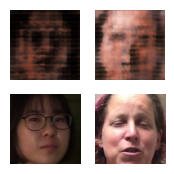

In [9]:
imgs, img_concats, audio_samples = khoas_get_batch(2, 100)
generate_and_save_images(gen, 100, imgs, img_concats, audio_samples, False)